In [3]:
from utils import balance_sample, univariate_classifier, correct_name_markers

import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as pgo
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)


from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
)
from sklearn.ensemble import ExtraTreesClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [4]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 8  # width in inches
fig_height = 8  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1.5,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
        'figure.figsize': fig_size
    },
)

sns.set_palette(sns.color_palette(nt_colors))

# Load Data

In [5]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']
# 
# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [6]:
df = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df = df.append(df_)
    
# df.to_csv('Data/all_markers.csv')

In [7]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se','msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b',]
#           'ft', 'ft_n']
erps =['CNV', 'P1', 'P3a', 'P3b']
# erps = [r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$']

# markers =  [r'$\delta$',r'$|\delta|$',r'$\theta$', r'$|\theta|$',r'$\alpha$', r'$|\alpha|$',r'$\beta$', r'$|\beta|$',r'$\gamma$', r'$|\gamma|$',
#             r'$PE\gamma$',r'$PE\beta$',r'$PE\alpha$',r'$PE\theta$',
#             r'$wSMI\gamma$',r'$wSMI\beta$',r'$wSMI\alpha$',r'$wSMI\theta$', 
#             r'$K$',r'$SE$',r'$MSF$', r'$SEF90$', r'$SEF95$', 
#             r'$CNV$', r'$P1$', r'$P3a$',r'$P3b$'
#            ]


# df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
# df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

# df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial < 5')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type', 'preproc', 'ft', 'ft_n'], axis = 1)
#               .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

# df_markers.to_csv('Data/all_markers.csv')

In [8]:
df_markers.groupby(['segment', 'participant']).first().groupby(['probe','mind']).agg('count')
# df_markers.groupby(['segment', 'participant']).first().groupby(['probe']).agg('count')

wSMI_1  wSMI_2  wSMI_4  wSMI_8  p_e_1  p_e_2  p_e_4  p_e_8  \
probe mind                                                                     
PC    about-task      82      82      82      82     82     82     82     82   
      dMW             39      39      39      39     39     39     39     39   
      distracted      48      48      48      48     48     48     48     48   
      on-task         94      94      94      94     94     94     94     94   
      sMW             43      43      43      43     43     43     43     43   
SC    about-task     200     200     200     200    200    200    200    200   
      dMW            286     286     286     286    286    286    286    286   
      distracted     199     199     199     199    199    199    199    199   
      on-task         10      10      10      10     10     10     10     10   
      sMW            250     250     250     250    250    250    250    250   

                    k   se  ...    t  t_n    d  d_n  a_n    a  CNV   P1  P3a  \
probe mind                  ...                                                
PC    about-task   82   82  ...   82   82   82   82   82   82   82   82   82   
      dMW          39   39  ...   39   39   39   39   39   39   39   39   39   
      distracted   48   48  ...   48   48   48   48   48   48   48   48   48   
      on-task      94   94  ...   94   94   94   94   94   94   94   94   94   
      sMW          43   43  ...   43   43   43   43   43   43   43   43   43   
SC    about-task  200  200  ...  200  200  200  200  200  200  200  200  200   
      dMW         286  286  ...  286  286  286  286  286  286  286  286  286   
      distracted  199  199  ...  199  199  199  199  199  199  199  199  199   
      on-task      10   10  ...   10   10   10   10   10   10   10   10   10   
      sMW         250  250  ...  250  250  250  250  250  250  250  250  250   

                  P3b  
probe mind             
PC    about-task   82  
      dMW          39  
      distracted   48  
      on-task      94  
      sMW          43  
SC    about-task  200  
      dMW         286  
      distracted  199  
      on-task      10  
      sMW         250  

[10 rows x 27 columns]

# Probe Caught

In [35]:
mind_states = ['on-task', 'about-task', 'distracted', 'dMW', 'sMW']
mind_dict = {'on-task':5, 'about-task':4, 'distracted':3, 'dMW':2, 'sMW':1}
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_probe = (
    df_markers
    .query("probe == 'PC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

# df_probe.columns = df_probe.columns.map("_".join)

# df_probe  = (df_probe
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'}) 
#              .assign(mind_order = lambda df: np.select([df.mind == 'on-task', df.mind == 'about-task', df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'], [5,4,3,2,1]) )
# #             .sort_values(by = 'mind_order')
#             .drop(['participant', 'probe', 'segment'], axis = 1)
#            )    


#### Use latex command for nmaes###
##it slow downs the computer, just for final figures.

df_probe = correct_name_markers(df_probe)

df_probe.columns = df_probe.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))


df_probe  = (df_probe
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment'})
             .assign(mind_order = lambda df: np.select([df.mind == 'on-task', df.mind == 'about-task', df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'], [5,4,3,2,1]) )
#             .sort_values(by = 'mind_order')
            .drop(['participant', 'probe', 'segment'], axis = 1)
           )   



df_all_probe = pd.DataFrame()

for i in mind_states:
    for j in mind_states:
        if i == j:
            break
        contrast = [i,j]
        df_mind =  df_probe.query(f"mind in {contrast}")
        
        AUC = []
        pvalues = {}
        for marker in df_mind.drop(['mind', 'mind_order'], axis = 1).columns:
            first = df_mind.query(f"mind == '{contrast[0]}'")[marker]
            second = df_mind.query(f"mind == '{contrast[1]}'")[marker]
            auc = roc_auc_score(df_mind['mind_order'], df_mind[marker])
            AUC.append([marker, auc])
            pvalues[marker] = mannwhitneyu(x = first, y = second).pvalue 

        df_auc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

        p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
        df_auc = (df_auc
                    .merge(p_df, on = 'markers', how = 'inner')
                    .assign(
                            p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                            significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                         (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                            balance = 'unbalance',
                            comparison = f"{i} vs {j}"
                            )
                  )
        
        df_all_probe = df_all_probe.append(df_auc)        
        
        AUC = []
        pvalues = {}
        for marker in df_mind.drop(['mind', 'mind_order'], axis = 1).columns:
            rus = RandomUnderSampler(random_state=42)# fit predictor and target variable

            mind_rus = rus.fit_resample(df_mind[marker].astype("float32").values.reshape(-1,1), df_mind.mind)

            df_mind_rus = pd.DataFrame(mind_rus[0], columns =['markers']).assign(mind = mind_rus[1], 
                                                                        mind_order = lambda df: np.select([df.mind == 'on-task', df.mind == 'about-task', 
                                                                                                           df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'],
                                                                                                          [5,4,3,2,1]))
            
            first = df_mind_rus.query(f"mind == '{contrast[0]}'")['markers']
            second = df_mind_rus.query(f"mind == '{contrast[1]}'")['markers']
            auc = roc_auc_score(df_mind_rus['mind_order'], df_mind_rus['markers'])
            AUC.append([marker, auc])
            pvalues[marker] = mannwhitneyu(x = first, y = second).pvalue  

        df_rus = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

        p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
        df_rus = (df_rus
                    .merge(p_df, on = 'markers', how = 'inner')
                    .assign(
                            p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                            significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                         (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                            balance = 'under-sample',
                            comparison = f"{i} vs {j}"
                            )
                  )
                        
        df_all_probe = df_all_probe.append(df_rus)
        
        
        AUC = []
        pvalues = {}
        for marker in df_mind.drop(['mind', 'mind_order'], axis = 1).columns:
            ros = SMOTE(random_state=42)# fit predictor and target variable

            mind_ros = ros.fit_resample(df_mind[marker].astype("float32").values.reshape(-1,1), df_mind.mind)

            df_mind_ros = pd.DataFrame(mind_ros[0], columns =['markers']).assign(mind = mind_ros[1],                                                                       
                                                                                 mind_order = lambda df: np.select([df.mind == 'on-task', df.mind == 'about-task', 
                                                                                                                 df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'],
                                                                                                          [5,4,3,2,1]))
            
            first = df_mind_ros.query(f"mind == '{contrast[0]}'")['markers']
            second = df_mind_ros.query(f"mind == '{contrast[1]}'")['markers']
            auc = roc_auc_score(df_mind_ros['mind_order'], df_mind_ros['markers'])
            AUC.append([marker, auc])
            pvalues[marker] = mannwhitneyu(x = first, y = second).pvalue  

        df_ros = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

        p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
        df_ros = (df_ros
                    .merge(p_df, on = 'markers', how = 'inner')
                    .assign(
                            p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                            significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                         (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                            balance = 'over-sample',
                            comparison = f"{i} vs {j}"
                            )
                  )
                        
        df_all_probe = df_all_probe.append(df_ros)

In [39]:
def plot_univariate(df, label, color = green, contrast = None):
    
    if contrast is not None:
        df = df.query(f"comparison == '{contrast}'")

    fig = px.scatter(df.sort_values(by = 'AUC'),x = 'AUC', y = 'markers', template = "plotly_white",
                     symbol = 'significant', symbol_sequence = ['circle-open','circle','hexagram' ], color_discrete_sequence = [color],

                     category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']}, 
                     labels = {'AUC': f'{label[0]}>{label[1]}                  {label[0]}<{label[1]}'}

                    )

    fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
    fig.update_traces(marker=dict(size = 8))

    fig.update_layout(
        autosize=False,
        width=800,
        height=1000,
        xaxis= {'range': (0.33, 0.67)},
        yaxis = {
                'showticklabels': True,
                'tickmode': 'linear',
            }

    )

    fig.show()

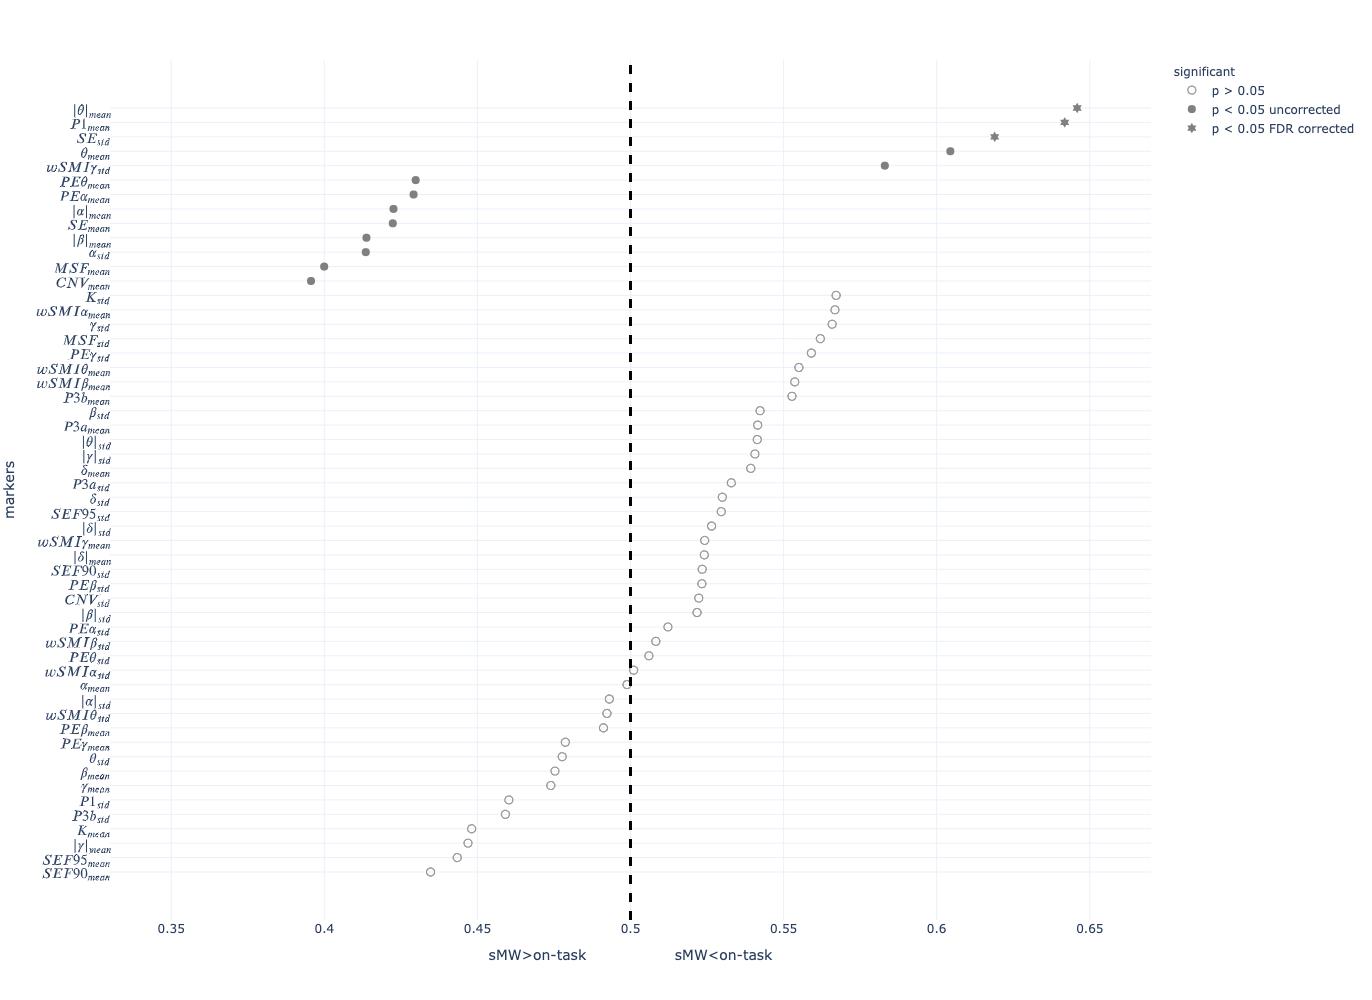

In [67]:
# segment_mind_roc = pd.read_csv('Data/univariate_roc_mind_segment.csv')
ot_contrasts = ['about-task vs on-task','distracted vs on-task', 'dMW vs on-task', 'sMW vs on-task']


plot_univariate(df = df_all_probe.query("balance == 'over-sample'"), contrast = ot_contrasts[3], label =['sMW', 'on-task'] , color = pink)


In [43]:
def symbol_fun(x):
    if  x== 'p < 0.05 FDR corrected':
        symbols = 'hexagram' 
    elif x == 'p < 0.05 uncorrected':
        symbols = 'circle'
    else:
        symbols = 'circle-open'
            
    return symbols

In [58]:
def hex_to_rgb(hex_color: str) -> tuple:
    hex_color = hex_color.lstrip("#")
    if len(hex_color) == 3:
        hex_color = hex_color * 2
    return int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)

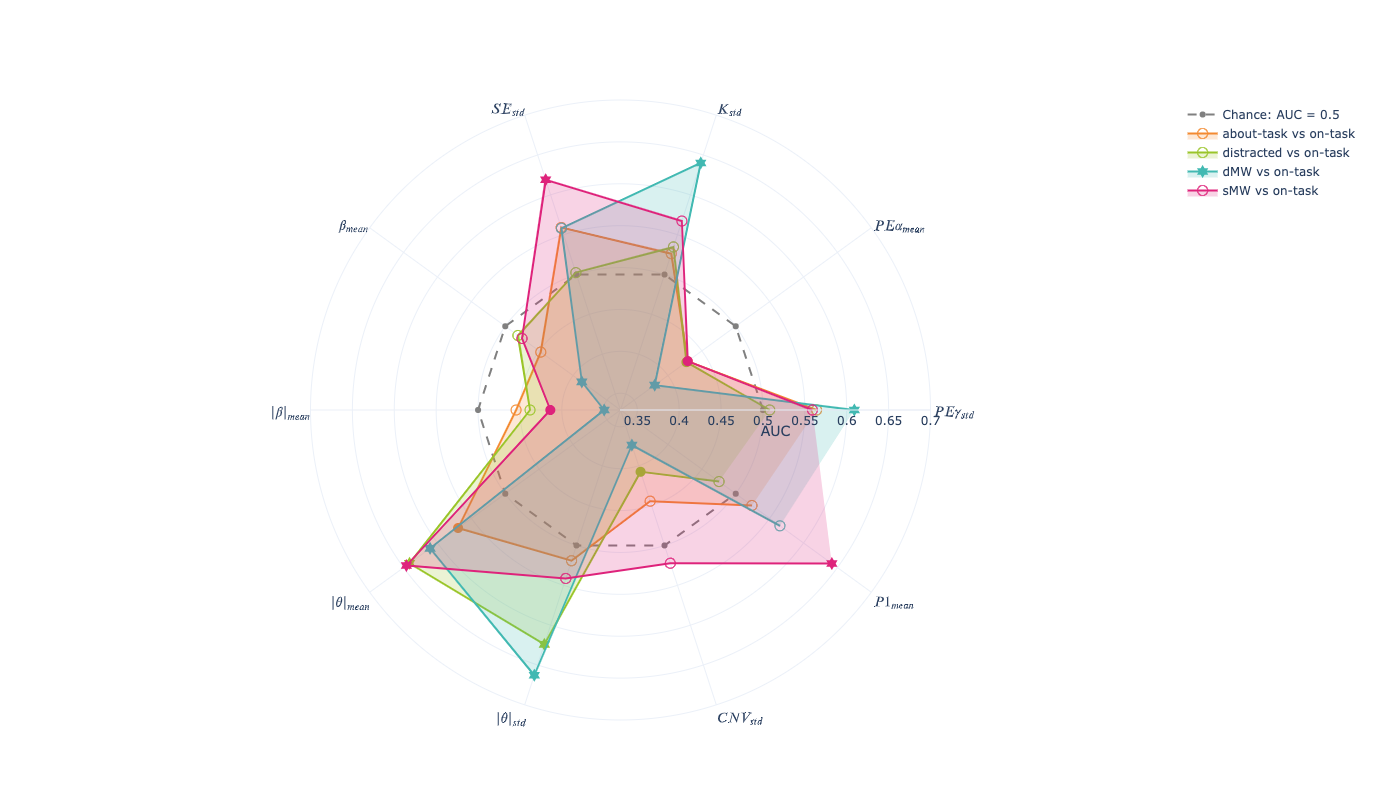

In [65]:
ot_contrasts = ['about-task vs on-task','distracted vs on-task', 'dMW vs on-task', 'sMW vs on-task']

df_ot_contrasts = df_all_probe.query(f"comparison in {ot_contrasts}").query("balance == 'over-sample'")
# significants = df_ot_contrasts.query("significant != 'p > 0.05'").markers.unique().tolist()
significants = df_ot_contrasts.query("significant == 'p < 0.05 FDR corrected'").markers.unique().tolist()


distracted_ot =df_ot_contrasts.query("comparison == 'distracted vs on-task'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
dmw_ot = df_ot_contrasts.query("comparison == 'dMW vs on-task'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
smw_ot = df_ot_contrasts.query("comparison == 'sMW vs on-task'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
about_task = df_ot_contrasts.query("comparison == 'about-task vs on-task'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))

fig = pgo.Figure()



fig.add_trace(pgo.Scatterpolar(
    r=np.ones(len(distracted_ot['markers'])) * 0.5,
    theta=distracted_ot['markers'],
    name = 'Chance: AUC = 0.5',
    mode = 'lines+markers',
    line = {'color':'grey', 'width': 2, 'dash': 'dash' },
))

fig.add_trace(pgo.Scatterpolar(
    r=about_task.AUC,
    theta=about_task['markers'],
    fill='toself',
    name='about-task vs on-task',
    mode = 'lines+markers',
    marker = {'color':orange, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(orange), 0.2)}",
    marker_symbol= about_task.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=distracted_ot.AUC,
    theta=distracted_ot['markers'],
    fill='toself',
    name='distracted vs on-task',
        mode = 'lines+markers',
    marker = {'color':green, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(green), 0.2)}",
    marker_symbol= distracted_ot.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=dmw_ot.AUC,
    theta=dmw_ot['markers'],
    fill='toself',
    name='dMW vs on-task',
    mode = 'lines+markers',
    marker = {'color':lblue, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(lblue), 0.2)}",
    marker_symbol= dmw_ot.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=smw_ot.AUC,
    theta=smw_ot['markers'],
    fill='toself',
    name='sMW vs on-task',
    mode = 'lines+markers',
    fillcolor= f"rgba{(*hex_to_rgb(pink), 0.2)}",
    marker = {'color':pink, 'size': 10,},
    marker_symbol= smw_ot.symbol.to_list()
))




fig.update_layout(
#     title="All against On-task for Significant markers",
#     legend_title="Classification",
    width=800,
    height=800,
    template = 'plotly_white',
    
  polar=dict(
    radialaxis=dict(
    title = 'AUC',
      visible=True,
        range = [0.33,0.7]
    ),
  ),
    
  showlegend=True
)

fig.show()
# pio.write_json(fig, 'Figs/radar_auc_significant.plotly')

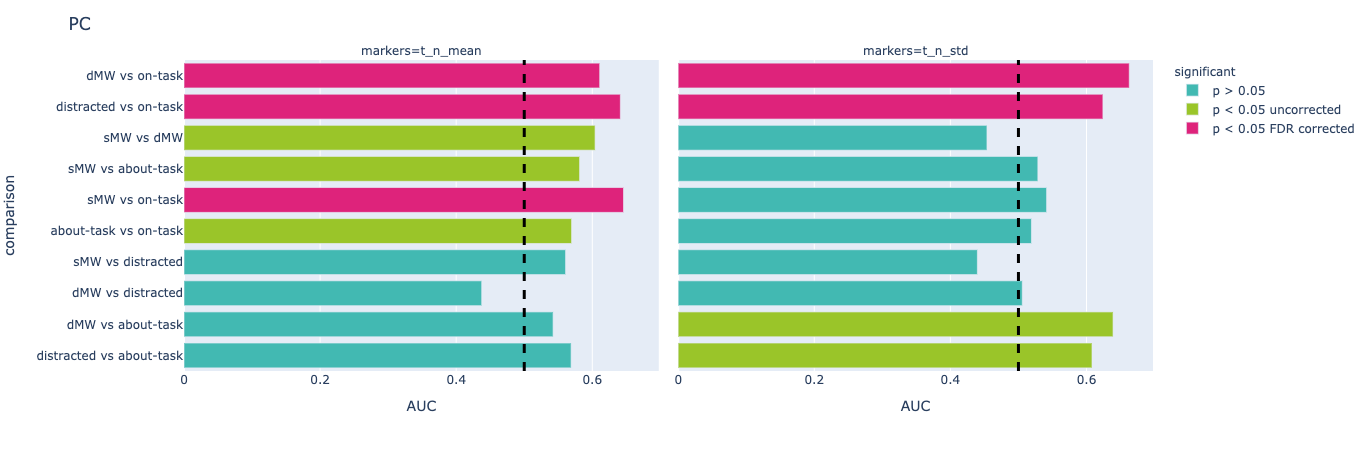

In [63]:
df_ot= df_all_probe.query("balance == 'over-sample'").query(f"markers in {['t_n_mean', 't_n_std', ]}") #'t_mean', 't_std', 'p_e_8_mean', 'p_e_8_std', 'wSMI_8_mean', 'wSMI_8_std'
fig = px.bar(df_ot, y = 'comparison', x='AUC', facet_col = 'markers', color = 'significant', color_discrete_sequence = [lblue, green, pink], 
                         category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_layout(
    title = 'PC',
    autosize=True,
#     width=800,
#     height=1600,
    xaxis = {
            'showticklabels': True,
#             'tickmode': 'linear',
        'range': [0.35, 0.67]
        },
#             xaxis = {'title': 'a'}

)

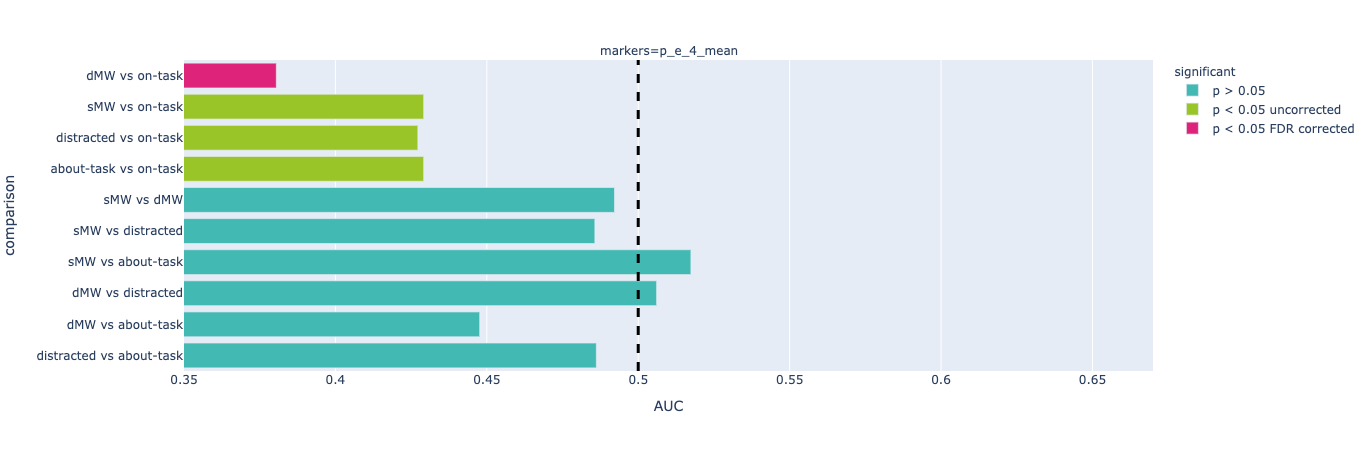

In [64]:
df_ot= df_all_probe.query("balance == 'over-sample'").query(f"markers in {['p_e_4_mean']}") #'t_mean', 't_std', 'p_e_8_mean', 'p_e_8_std', 'wSMI_8_mean', 'wSMI_8_std'
fig = px.bar(df_ot, y = 'comparison', x='AUC', facet_col = 'markers', color = 'significant', color_discrete_sequence = [lblue, green, pink], 
                         category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_layout(
#     title = 'PC',
    autosize=True,
#     width=1600,
#     height=800,
    xaxis = {
            'showticklabels': True,
            
        'range': [0.35, 0.67]
        },
#             xaxis = {'title': 'a'}

)

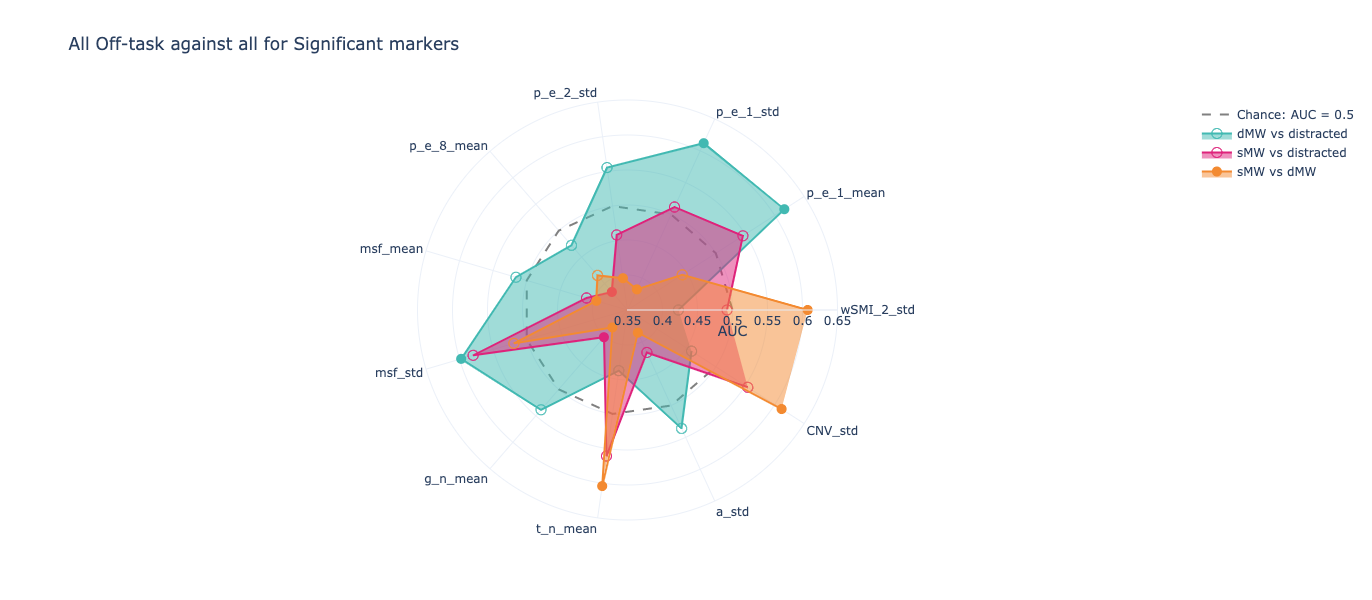

In [65]:
off_contrasts = [ 'dMW vs distracted', 'sMW vs distracted','sMW vs dMW']

df_off_contrasts = df_all_probe.query(f"comparison in {off_contrasts}").query("balance == 'over-sample'")
significants = df_off_contrasts.query("significant != 'p > 0.05'").markers.unique().tolist()

distracted_dmw =df_off_contrasts.query("comparison == 'dMW vs distracted'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
distracted_smw = df_off_contrasts.query("comparison == 'sMW vs distracted'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
dmw_smw = df_off_contrasts.query("comparison == 'sMW vs dMW'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))

fig = pgo.Figure()



fig.add_trace(pgo.Scatterpolar(
    r=np.ones(len(distracted_dmw['markers'])) * 0.5,
    theta=distracted_dmw['markers'],
    name = 'Chance: AUC = 0.5',
    mode = 'lines',
    line = {'color':'grey', 'width': 2, 'dash': 'dash' },
))

fig.add_trace(pgo.Scatterpolar(
    r=distracted_dmw.AUC,
    theta=distracted_dmw['markers'],
    fill='toself',
    name= 'dMW vs distracted', 
    marker = {'color':lblue, 'size': 10},
    marker_symbol= distracted_dmw.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=distracted_smw.AUC,
    theta=distracted_smw['markers'],
    fill='toself',
    name='sMW vs distracted',
    marker = {'color':pink, 'size': 10},
    marker_symbol= distracted_smw.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=dmw_smw.AUC,
    theta=dmw_smw['markers'],
    fill='toself',
    name='sMW vs dMW',
    marker = {'color':orange, 'size': 10},
    marker_symbol= dmw_smw.symbol.to_list()
))




fig.update_layout(
    title="All Off-task against all for Significant markers",
#     legend_title="Classification",
    width=600,
    height=600,
    template = 'plotly_white',
    polar=dict(
    radialaxis=dict(
    title = 'AUC',
      visible=True,
        range = [0.35,0.65]
    ),
  ),
    showlegend=True
)

fig.show()
# pio.write_json(fig, 'Figs/radar_auc_significant.plotly')

# Self Caught

In [68]:
mind_states = ['about-task', 'distracted', 'dMW', 'sMW']
mind_dict = {'about-task':4, 'distracted':3, 'dMW':2, 'sMW':1}
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_self = (
    df_markers
    .query("probe == 'SC'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

# df_self.columns = df_self.columns.map("_".join)

# df_self  = (df_self
#             .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'}) 
#              .assign(mind_order = lambda df: np.select([df.mind == 'about-task', df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'], [4,3,2,1]) )
# #             .sort_values(by = 'mind_order')
#             .drop(['participant', 'probe', 'segment'], axis = 1)
#            )    


df_self = correct_name_markers(df_self)

df_self.columns = df_self.columns.map("$_{".join).map(lambda x: x + '}$').map(lambda x: x.replace('$$', ''))


df_self  = (df_self
            .rename(columns = {'participant$_{first}$':'participant', 'probe$_{first}$':'probe', 'mind$_{first}$':'mind', 'segment$_{first}$':'segment'})
             .assign(mind_order = lambda df: np.select([ df.mind == 'about-task', df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'], [4,3,2,1]) )
#             .sort_values(by = 'mind_order')
            .drop(['participant', 'probe', 'segment'], axis = 1)
           )   


df_all_self = pd.DataFrame()

for i in mind_states:
    for j in mind_states:
        if i == j:
            break
        contrast = [i,j]
        df_mind =  df_self.query(f"mind in {contrast}")
        
        AUC = []
        pvalues = {}
        for marker in df_mind.drop(['mind', 'mind_order'], axis = 1).columns:
            first = df_mind.query(f"mind == '{contrast[0]}'")[marker]
            second = df_mind.query(f"mind == '{contrast[1]}'")[marker]
            auc = roc_auc_score(df_mind['mind_order'], df_mind[marker])
            AUC.append([marker, auc])
            pvalues[marker] = mannwhitneyu(x = first, y = second).pvalue 

        df_auc = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

        p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
        df_auc = (df_auc
                    .merge(p_df, on = 'markers', how = 'inner')
                    .assign(
                            p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                            significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                         (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                            balance = 'unbalance',
                            comparison = f"{i} vs {j}"
                            )
                  )
        
        df_all_self = df_all_self.append(df_auc)        
        
        AUC = []
        pvalues = {}
        for marker in df_mind.drop(['mind', 'mind_order'], axis = 1).columns:
            rus = RandomUnderSampler(random_state=42)# fit predictor and target variable

            mind_rus = rus.fit_resample(df_mind[marker].astype("float32").values.reshape(-1,1), df_mind.mind)

            df_mind_rus = pd.DataFrame(mind_rus[0], columns =['markers']).assign(mind = mind_rus[1], 
                                                                        mind_order = lambda df: np.select([ df.mind == 'about-task', 
                                                                                                           df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'],
                                                                                                          [4,3,2,1]))
            
            first = df_mind_rus.query(f"mind == '{contrast[0]}'")['markers']
            second = df_mind_rus.query(f"mind == '{contrast[1]}'")['markers']
            auc = roc_auc_score(df_mind_rus['mind_order'], df_mind_rus['markers'])
            AUC.append([marker, auc])
            pvalues[marker] = mannwhitneyu(x = first, y = second).pvalue  

        df_rus = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

        p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
        df_rus = (df_rus
                    .merge(p_df, on = 'markers', how = 'inner')
                    .assign(
                            p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                            significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                         (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                            balance = 'under-sample',
                            comparison = f"{i} vs {j}"
                            )
                  )
                        
        df_all_self = df_all_self.append(df_rus)
        
        
        AUC = []
        pvalues = {}
        for marker in df_mind.drop(['mind', 'mind_order'], axis = 1).columns:
            ros = RandomOverSampler(random_state=42)# fit predictor and target variable

            mind_ros = ros.fit_resample(df_mind[marker].astype("float32").values.reshape(-1,1), df_mind.mind)

            df_mind_ros = pd.DataFrame(mind_ros[0], columns =['markers']).assign(mind = mind_ros[1],                                                                       
                                                                                 mind_order = lambda df: np.select([ df.mind == 'about-task', 
                                                                                                                 df.mind == 'distracted',df.mind == 'dMW', df.mind == 'sMW'],
                                                                                                          [4,3,2,1]))
            
            first = df_mind_ros.query(f"mind == '{contrast[0]}'")['markers']
            second = df_mind_ros.query(f"mind == '{contrast[1]}'")['markers']
            auc = roc_auc_score(df_mind_ros['mind_order'], df_mind_ros['markers'])
            AUC.append([marker, auc])
            pvalues[marker] = mannwhitneyu(x = first, y = second).pvalue  

        df_ros = pd.DataFrame(AUC, columns = ['markers', 'AUC'])

        p_df =pd.DataFrame.from_dict(pvalues, orient = 'index', columns = ['p_value']).reset_index().rename(columns ={'index': 'markers'})
        df_ros = (df_ros
                    .merge(p_df, on = 'markers', how = 'inner')
                    .assign(
                            p_corrected = lambda df: multipletests(df.p_value, method = 'fdr_bh')[1],
                            significant = lambda df: np.select([(df.p_value < 0.05) & (df.p_corrected < 0.05), (df.p_value < 0.05) & (df.p_corrected > 0.05),  
                                                         (df.p_value > 0.05) & (df.p_corrected > 0.05)], ['p < 0.05 FDR corrected','p < 0.05 uncorrected', 'p > 0.05']),
                            balance = 'over-sample',
                            comparison = f"{i} vs {j}"
                            )
                  )
                        
        df_all_self = df_all_self.append(df_ros)

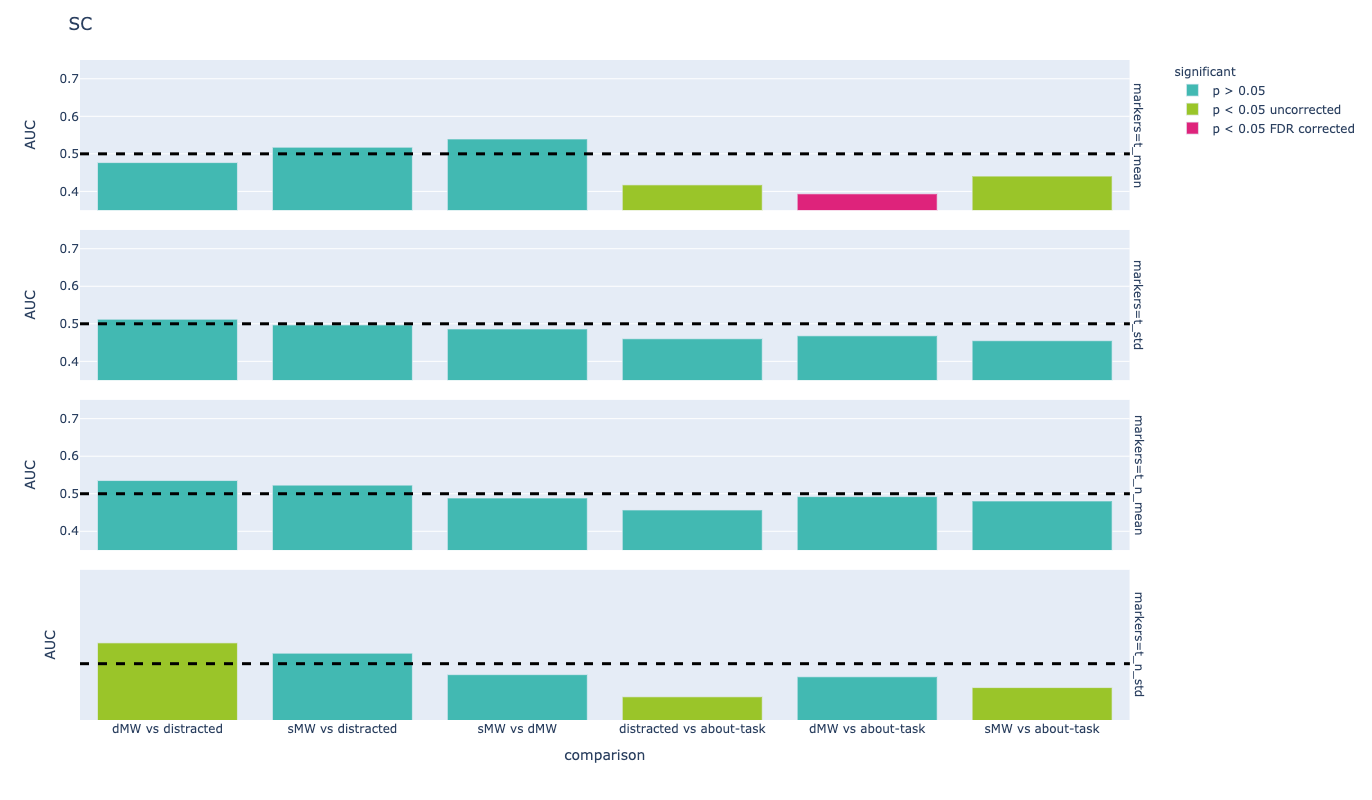

In [69]:
df_ot= df_all_self.query("balance == 'unbalance'").query(f"markers in {['t_n_mean', 't_n_std', 't_mean', 't_std']}") #'p_e_8_mean', 'p_e_8_std', 'wSMI_8_mean', 'wSMI_8_std'
fig = px.bar(df_ot, x = 'comparison', y='AUC', facet_row = 'markers', color = 'significant', color_discrete_sequence = [lblue, green, pink], 
                         category_orders = {'significant': ['p > 0.05','p < 0.05 uncorrected', 'p < 0.05 FDR corrected']})
fig.add_hline(y=0.5, line_width=3, line_dash="dash", line_color="black")

fig.update_layout(
    title = 'SC',
    autosize=False,
    width=1600,
    height=800,
    yaxis = {
            'showticklabels': True,
            'tickmode': 'linear',
        'range': [0.35, 0.75]
        },
#             xaxis = {'title': 'a'}

)

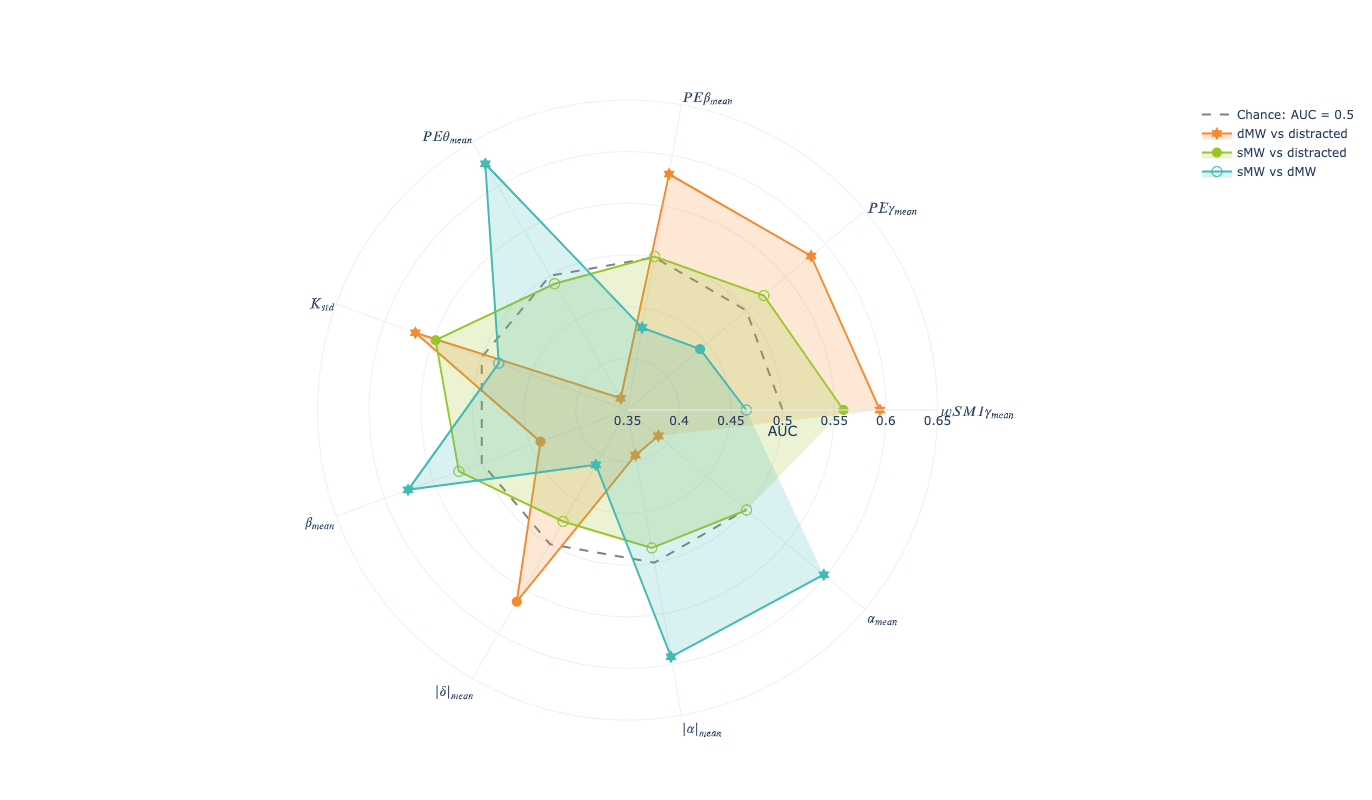

In [71]:
off_contrasts = [ 'dMW vs distracted', 'sMW vs distracted','sMW vs dMW']

df_off_contrasts = df_all_self.query(f"comparison in {off_contrasts}").query("balance == 'unbalance'")
significants = df_off_contrasts.query("significant == 'p < 0.05 FDR corrected'").markers.unique().tolist()

distracted_dmw =df_off_contrasts.query("comparison == 'dMW vs distracted'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
distracted_smw = df_off_contrasts.query("comparison == 'sMW vs distracted'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
dmw_smw = df_off_contrasts.query("comparison == 'sMW vs dMW'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))

fig = pgo.Figure()



fig.add_trace(pgo.Scatterpolar(
    r=np.ones(len(distracted_dmw['markers'])) * 0.5,
    theta=distracted_dmw['markers'],
    name = 'Chance: AUC = 0.5',
    mode = 'lines',
    line = {'color':'grey', 'width': 2, 'dash': 'dash' },
))

fig.add_trace(pgo.Scatterpolar(
    r=distracted_dmw.AUC,
    theta=distracted_dmw['markers'],
    fill='toself',
    name= 'dMW vs distracted', 
    marker = {'color':orange, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(orange), 0.2)}",
    marker_symbol= distracted_dmw.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=distracted_smw.AUC,
    theta=distracted_smw['markers'],
    fill='toself',
    name='sMW vs distracted',
    marker = {'color':green, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(green), 0.2)}",
    marker_symbol= distracted_smw.symbol.to_list()
))

fig.add_trace(pgo.Scatterpolar(
    r=dmw_smw.AUC,
    theta=dmw_smw['markers'],
    fill='toself',
    name='sMW vs dMW',
    marker = {'color':lblue, 'size': 10},
    fillcolor= f"rgba{(*hex_to_rgb(lblue), 0.2)}",
    marker_symbol= dmw_smw.symbol.to_list()
))




fig.update_layout(
#     title="All Off-task against all for Significant markers",
#     legend_title="Classification",
    width=800,
    height=800,
    template = 'plotly_white',
    polar=dict(
    radialaxis=dict(
    title = 'AUC',
      visible=True,
        range = [0.35,0.65]
    ),
  ),
    showlegend=True
)

fig.show()
# pio.write_json(fig, 'Figs/radar_auc_significant.plotly')

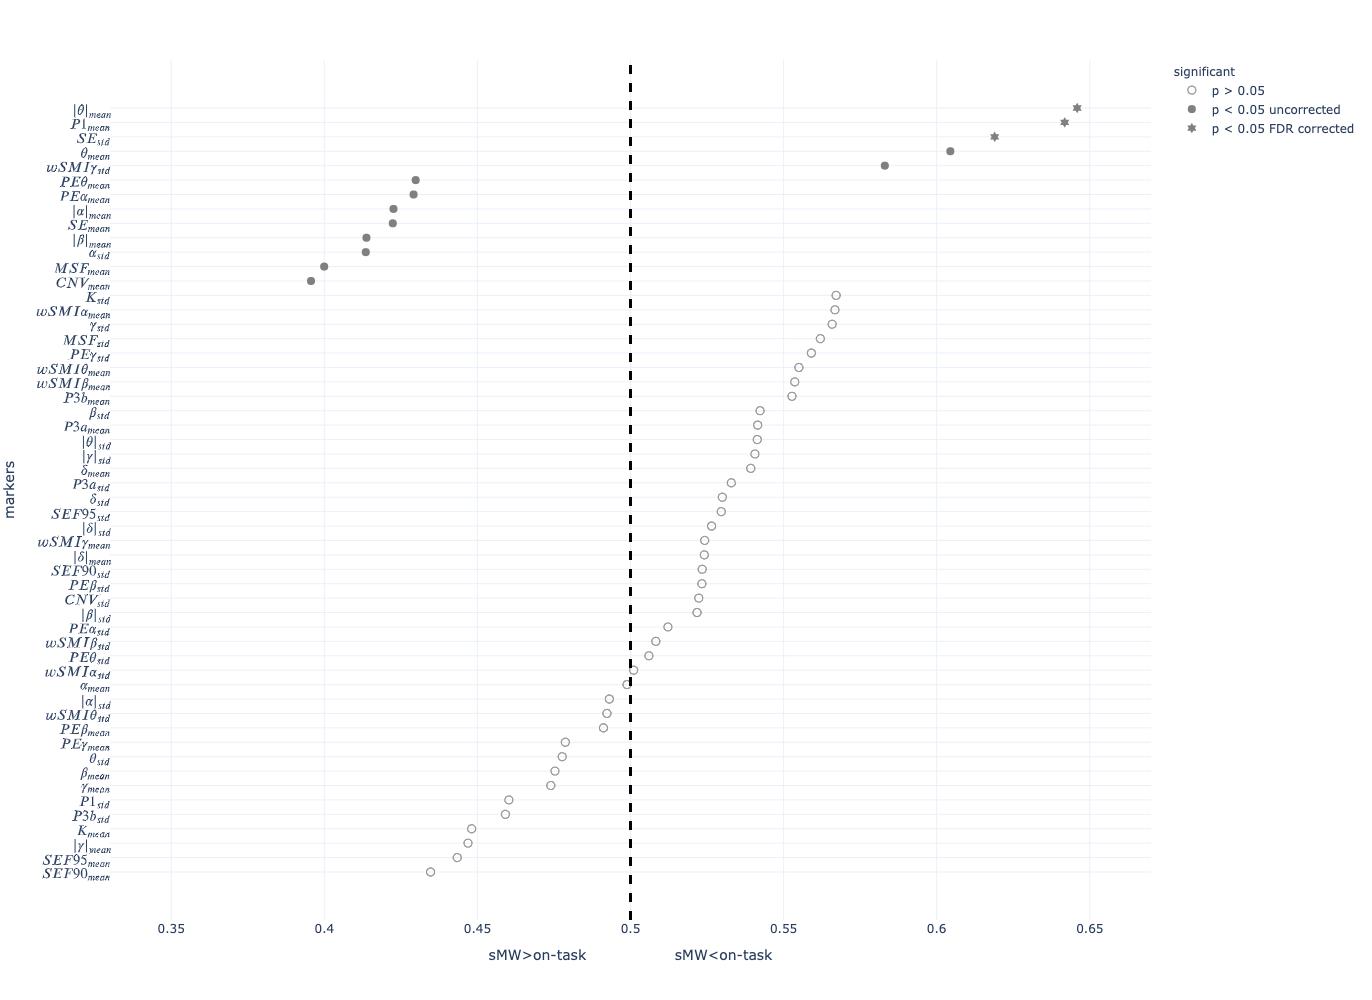

In [67]:
# segment_mind_roc = pd.read_csv('Data/univariate_roc_mind_segment.csv')
ot_contrasts = ['about-task vs on-task','distracted vs on-task', 'dMW vs on-task', 'sMW vs on-task']


plot_univariate(df = df_all_probe.query("balance == 'over-sample'"), contrast = ot_contrasts[3], label =['sMW', 'on-task'] , color = pink)


# PC vs SC for each comparison

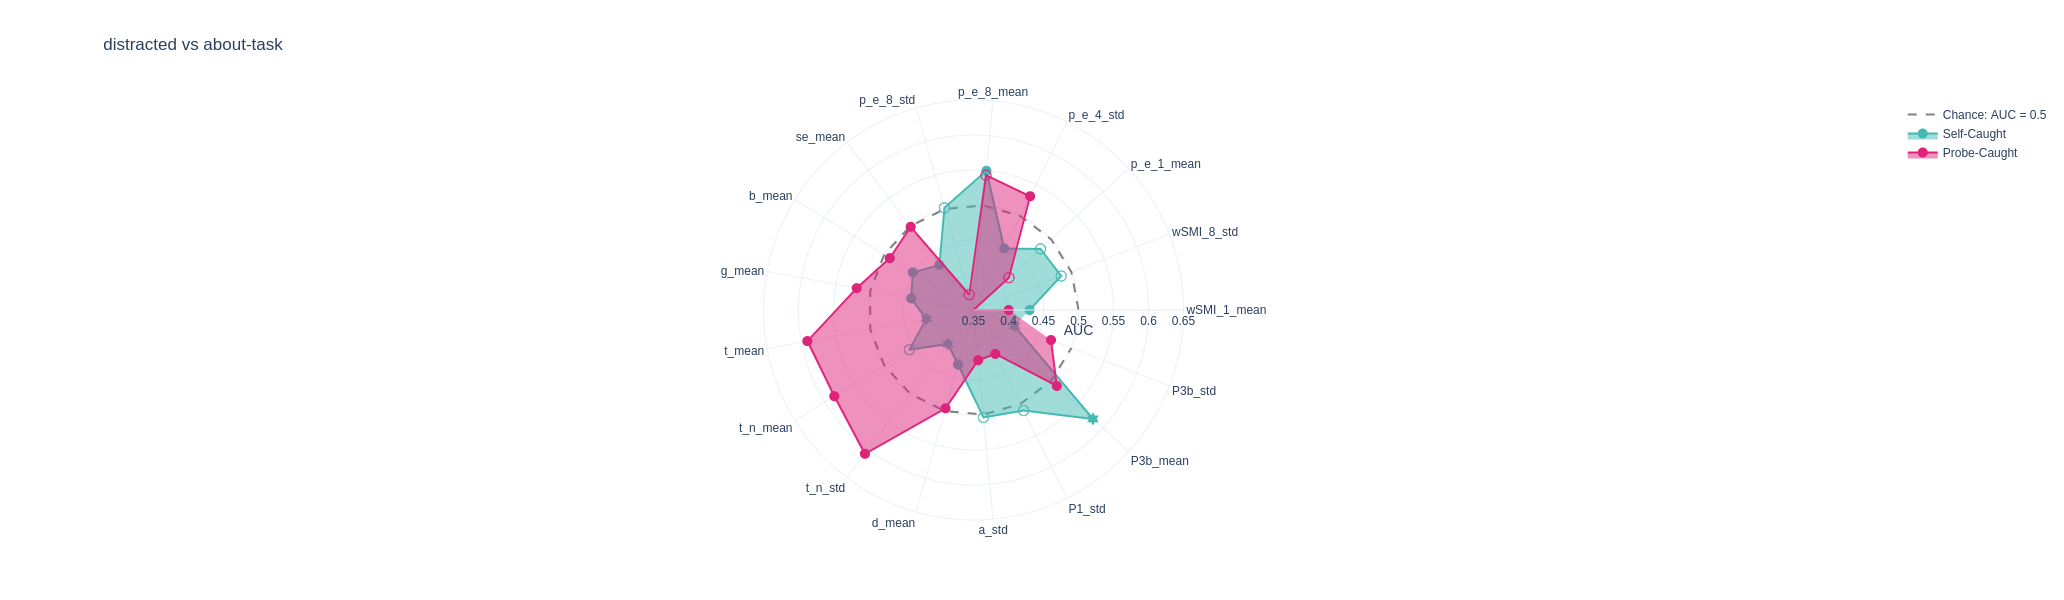

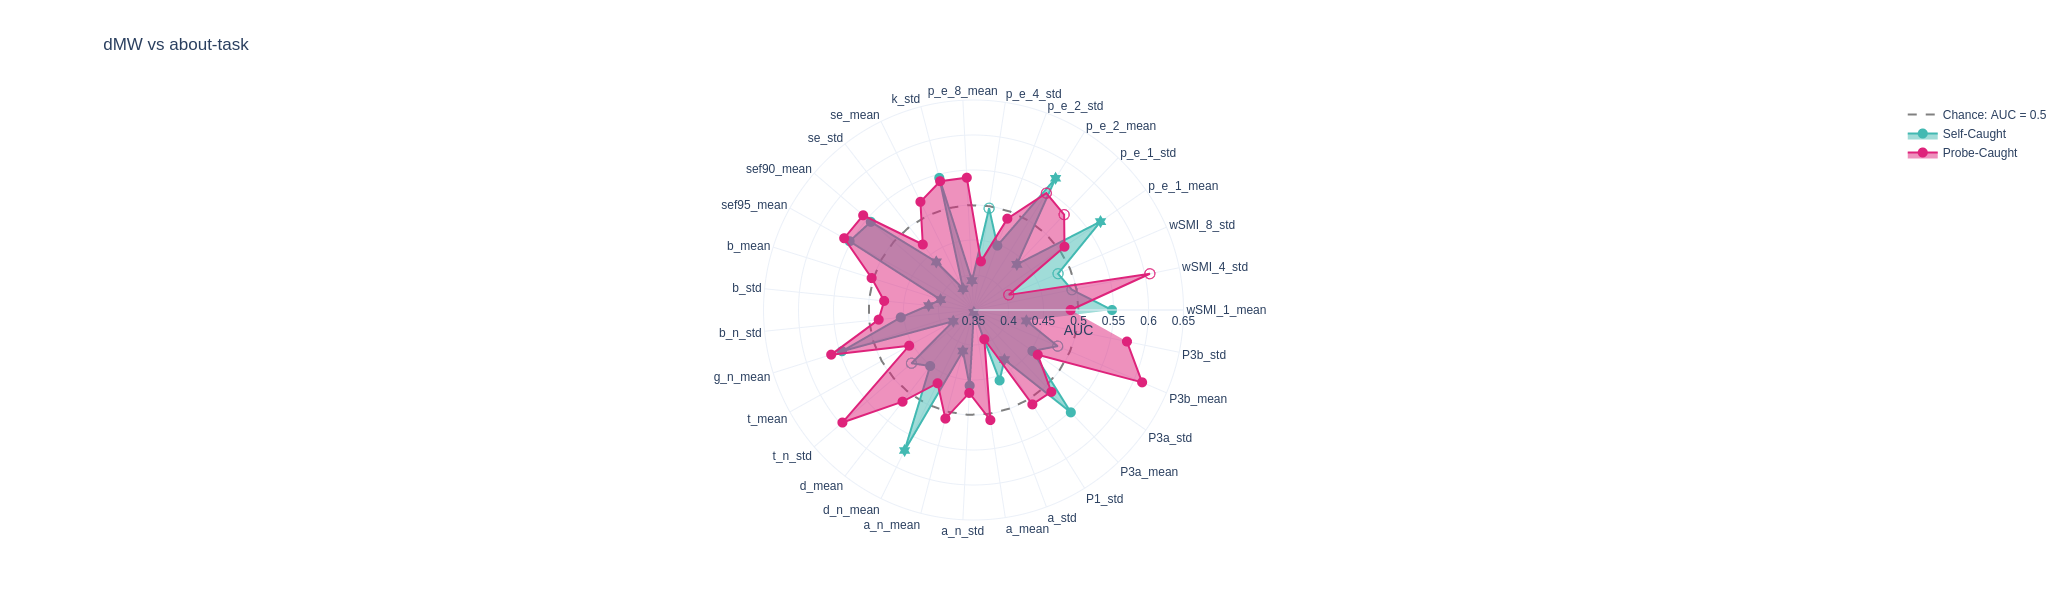

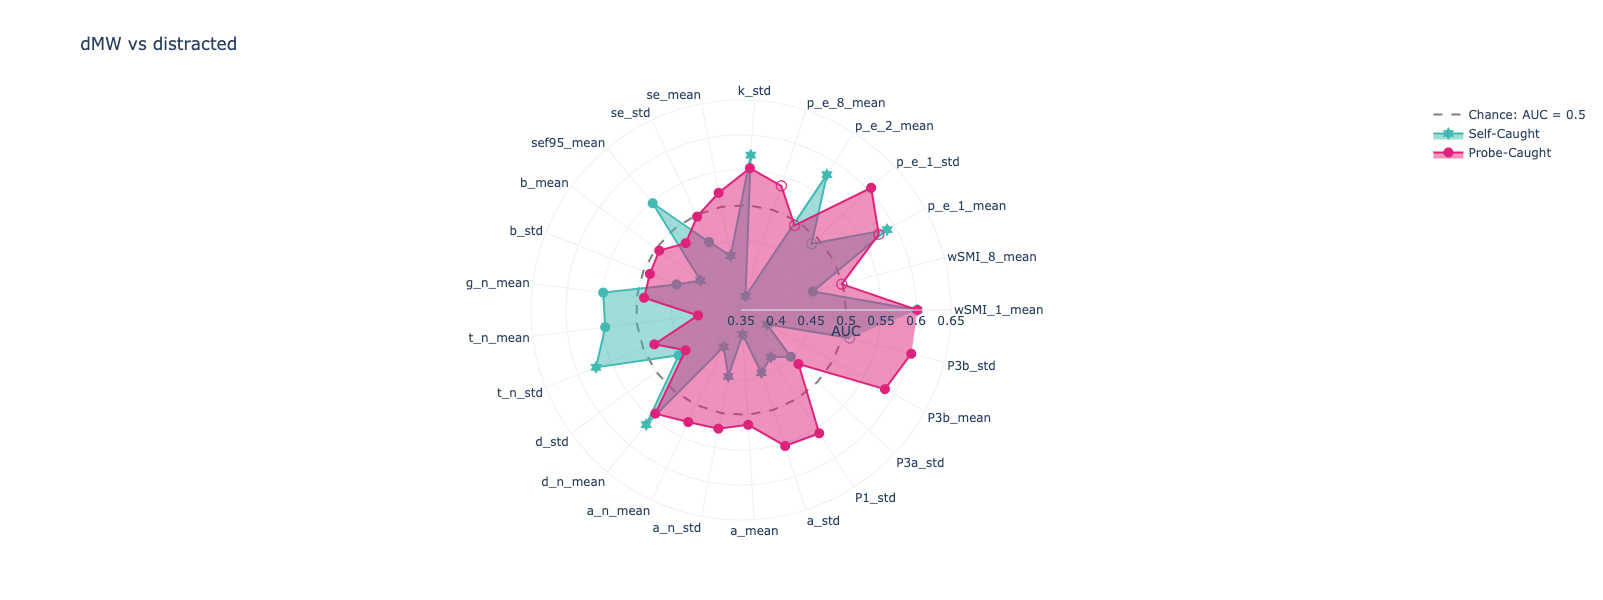

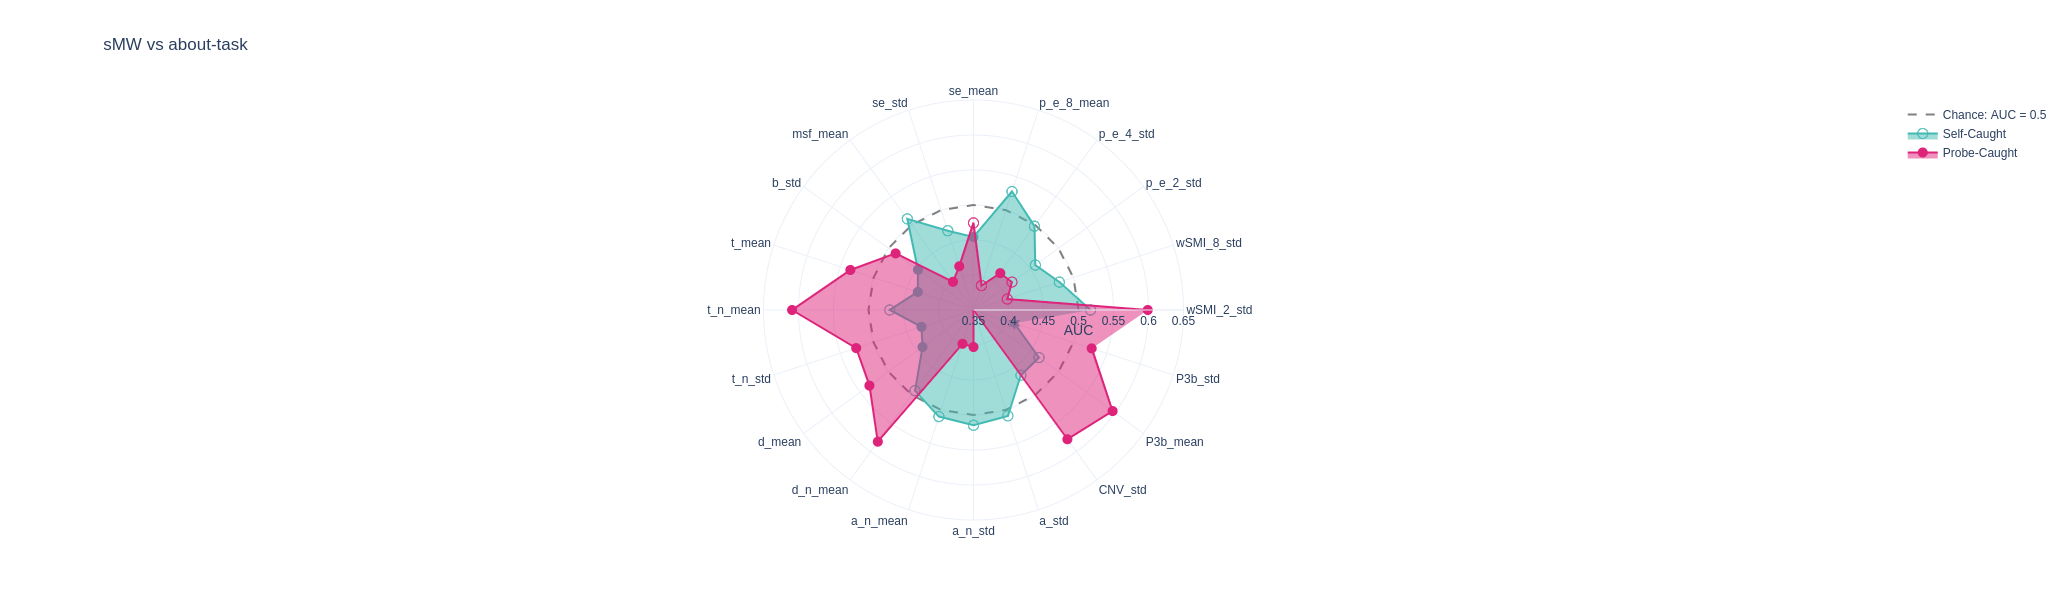

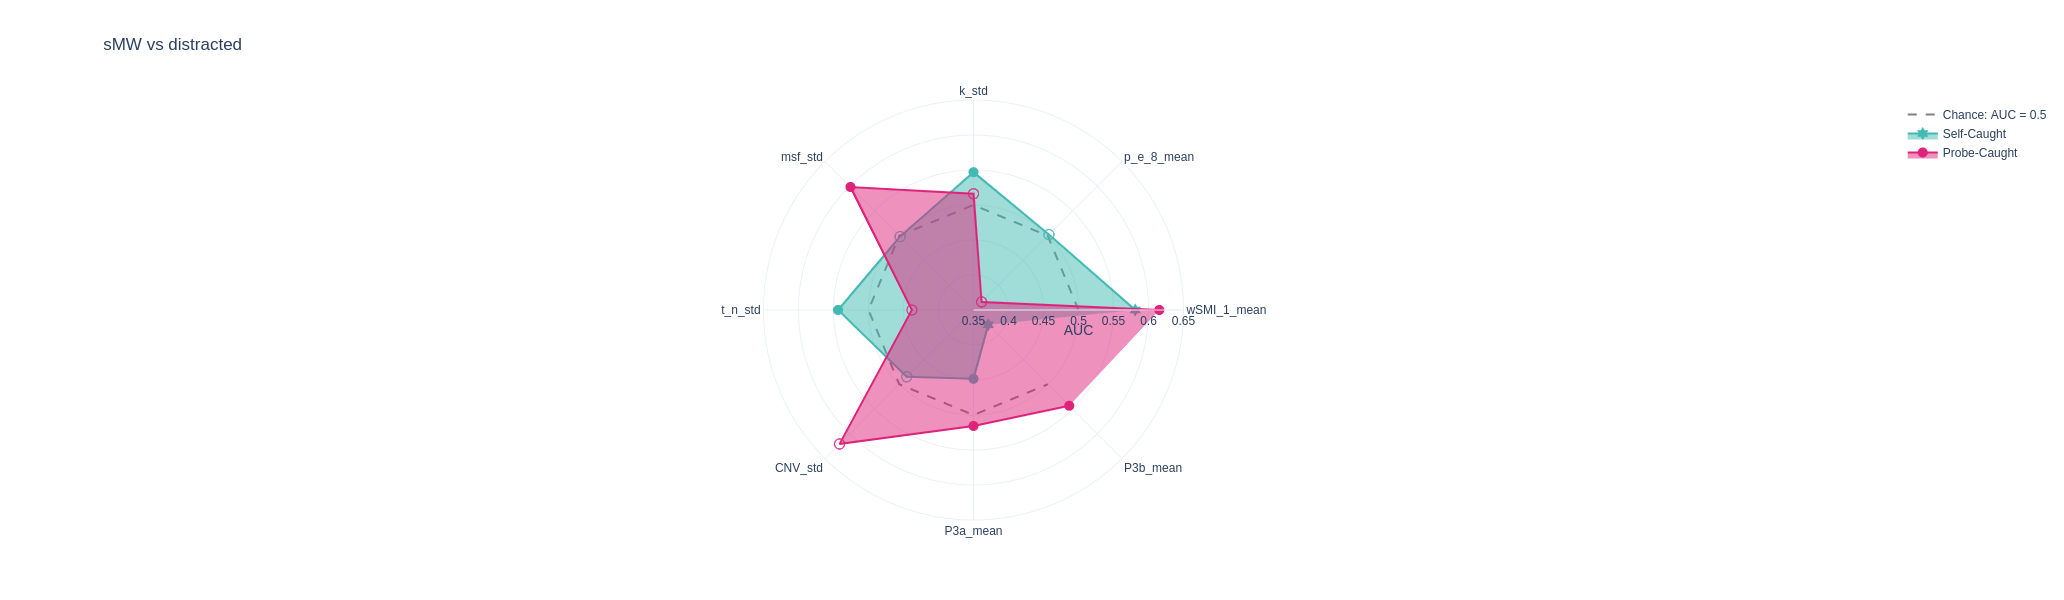

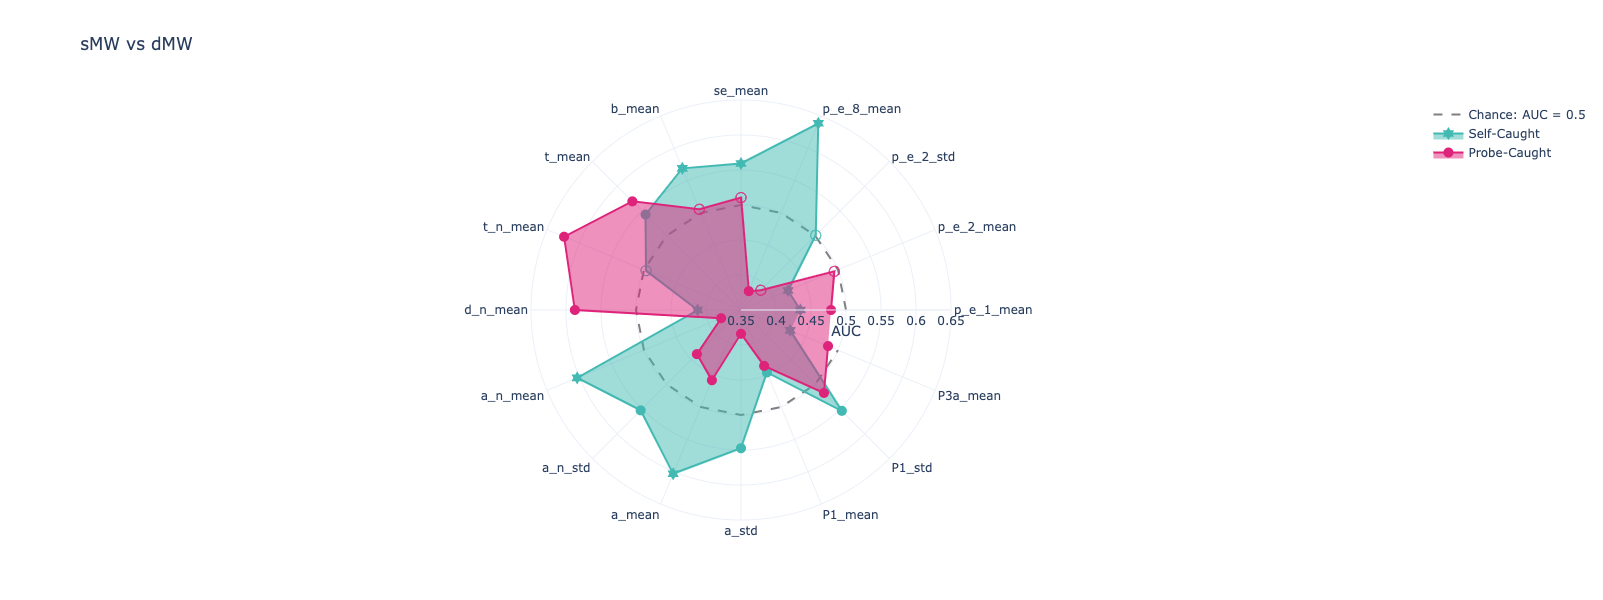

In [380]:
mind_states = ['about-task', 'distracted', 'dMW', 'sMW']
mind_dict = {'about-task':4, 'distracted':3, 'dMW':2, 'sMW':1}

df_all_self['probe'] = 'SC'
df_all_probe['probe'] = 'PC'
df_all = df_all_self.append(df_all_probe)

for i in mind_states:
    for j in mind_states:
        if i == j:
            break
        contrast = f"{i} vs {j}"
        label = sorted([i,j], key = mind_dict.get)
        
        df_contrast = df_all.query(f"comparison == '{contrast}'").query("balance == 'over-sample'")
        significants = df_contrast.query("significant != 'p > 0.05'").markers.unique().tolist()

        sc =df_contrast.query("probe == 'SC'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))
        pc = df_contrast.query("probe == 'PC'").query(f'markers in {significants}').assign(symbol = lambda df: df.significant.apply(symbol_fun))

        fig = pgo.Figure()



        fig.add_trace(pgo.Scatterpolar(
            r=np.ones(len(sc['markers'])) * 0.5,
            theta=sc['markers'],
            name = 'Chance: AUC = 0.5',
            mode = 'lines',
            line = {'color':'grey', 'width': 2, 'dash': 'dash' },
        ))

        fig.add_trace(pgo.Scatterpolar(
            r=sc.AUC,
            theta=sc['markers'],
            fill='toself',
            name= 'Self-Caught', 
            mode = 'lines+markers',
            marker = {'color':lblue, 'size': 10},
            marker_symbol= sc.symbol.to_list()
        ))

        fig.add_trace(pgo.Scatterpolar(
            r=pc.AUC,
            theta=pc['markers'],
            fill='toself',
            name='Probe-Caught',
            mode = 'lines+markers',
            marker = {'color':pink, 'size': 10},
            marker_symbol= distracted_smw.symbol.to_list()
        ))


        fig.update_layout(
            title=contrast,
        #     legend_title="Classification",
            width=600,
            height=600,
            template = 'plotly_white',
            polar=dict(
            radialaxis=dict(
            title = 'AUC',
              visible=True,
                range = [0.35,0.65]
            ),
          ),
            showlegend=True
        )

        fig.show()